In [1]:
#import libraries
# uncomment the installation commands if the package is not available.

import warnings
warnings.filterwarnings("ignore")  # supress warnings in output

import os
import pandas as pd
import numpy as np
import string
import regex as re
import itertools
from datetime import datetime

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk import tokenize
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
#conda install -c conda-forge wordcloud
from wordcloud import WordCloud
#pip install num2words
from num2words import num2words

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

C:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:17: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping, defaultdict
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
C:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# Constant Values
FOX = "Fox"
CNN = "CNN"
MSNBC = "MSNBC"
REAL = "REAL"
FAKE = "FAKE"
TARGET_NAMES = [REAL, FAKE]

MON_DD_YYYY = "%B %d, %Y"  # MON represents full name of the month
DD_MMM_YY = "%d-%b-%y"

# Column Names
TARGET = 'target'
TEXT = 'text'
TITLE = 'title'
DATE = 'date'
SUBJECT = 'subject'
STATION = 'station'

# File Names
Fake_data_file_name = 'Fake.csv'
True_data_file_name = 'True.csv'
Validation_1_data_file_name = 'Validation1.xls'  # 2017 news data set
Validation_2_data_file_name = 'Validation2.xls'  # 2021 news data set

# Read Data

In [3]:
# Read data from file
def read_csv_data(file_name):
    folder = os.getcwd()
    if os.path.isfile(file_name):
        raw_data = pd.read_csv(file_name)
    else:
        print ("Error: " + file_name +" does not exist in ", folder)
        
    return raw_data

def read_excel_data(file_name):
    folder = os.getcwd()
    if os.path.isfile(file_name):
        raw_data = pd.read_excel(file_name)
    else:
        print ("Error: " + file_name +" does not exist in ", folder)
        
    return raw_data

fake = read_csv_data(Fake_data_file_name)
true = read_csv_data(True_data_file_name)
validation1 = read_excel_data(Validation_1_data_file_name)
validation2 = read_excel_data(Validation_2_data_file_name)

In [4]:
# Flag added to differentiate fake and real data. This is the target variable
fake[TARGET] = FAKE
true[TARGET] = REAL

# Concatenate two data sets
data = pd.concat([fake, true]).reset_index(drop = True)

# Shuffle data to prevent bias
data = shuffle(data)
data = data.reset_index(drop = True)

## Data Cleaning

In [5]:
def punctuation_removal(text):
    all_list = [char for char in text if char not in "!\"#$%&()*+-./:;<=>?@[\]^_`{|}~\n"] # apostrophe excluded from list. 
    clean_str = ''.join(all_list)
    return clean_str

# Convert numbers to words in the text using num2words package
def convert_numbers_to_words(data):
    tokens = word_tokenize(str(data))
    new_text = ""
    for w in tokens:
        try:
            w = num2words(int(w))
        except:
            a = 0
        new_text = new_text + " " + w
    new_text = np.char.replace(new_text, "-", " ")
    return new_text

# Perform Lemmatization to identify inflectional endings and return dictionary or root form of the word
def Lemmating(data):
    lemmater= WordNetLemmatizer()
    
    tokens = word_tokenize(str(data))
    new_text = ""
    for w in tokens:
        new_text = new_text + " " + lemmater.lemmatize(w)
    return new_text


In [6]:
def text_cleaning(text):
    stop = stopwords.words('english')
    text = text.astype(str)
    text = text.apply(lambda x: x.lower()) # convert to lower case
    text = text.apply(lambda x: re.sub(r"http\S+|www\S+|https\S+", '', x, flags=re.MULTILINE))  # remove urls and links
    text = text.apply(punctuation_removal)
    text = text.apply(convert_numbers_to_words) # convert numbers to words
    text = text.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))  # remove stopwords
    text = text.apply(Lemmating)
    text = text.apply(punctuation_removal)    
    text = text.apply(lambda x: np.char.replace(x, "'", "")) # remove apostrophe
    text = text.apply(lambda x: ' '.join( [w for w in x.split() if len(w)>1] )) # remove single characters
    return text

def date_cleaning(date):
    # Convert month names to full month names
    date = date.str.replace('Jan ', 'January ')
    date = date.str.replace('Feb ', 'February ')
    date = date.str.replace('Mar ', 'March ')
    date = date.str.replace('Apr ', 'April ')
    date = date.str.replace('Jun ', 'June ')
    date = date.str.replace('Jul ', 'July ')
    date = date.str.replace('Aug ', 'August ')
    date = date.str.replace('Sep ', 'September ')
    date = date.str.replace('Oct ', 'October ')
    date = date.str.replace('Nov ', 'November ')
    date = date.str.replace('Dec ', 'December ')
    date = date.str.strip()
    
    return date

In [7]:
data[SUBJECT] = data[SUBJECT].replace('politicsNews', 'politics')
data[SUBJECT] = data[SUBJECT].replace('_', '-')

data[TEXT] = text_cleaning(data[TEXT])
data[DATE] = date_cleaning(data[DATE])

# drop values where the data is not correct in Date field
data = data[data.date.str.len() <= 18]  
data.date = data.date.apply(lambda x: datetime.strptime(x, MON_DD_YYYY) if (len(x) > 9 & len(x) < 18) else datetime.strptime(x, DD_MMM_YY))

data['year'] = data[DATE].dt.to_period('Y')
data['month'] = data[DATE].dt.to_period('M')
data['month'] = data['month'].astype(str)

In [8]:
data.head(10)

,title,text,subject,date,target,year,month
0,Ship carrying migrants sinks off Turkish coast...,ankara reuters fifteen people drowned fishing ...,worldnews,2017-09-22,REAL,2017,2017-09
1,"Wealthy, educated voters fuel Trump's East Coa...",washingtonbethesda md reuters wealthy welleduc...,politics,2016-04-28,REAL,2016,2016-04
2,"Pope, on Christmas Eve, says faith demands res...",vatican city reuters pope francis strongly def...,worldnews,2017-12-24,REAL,2017,2017-12
3,PRESIDENT TRUMP Explains New “America First” R...,talking another campaign promise kept wonder d...,politics,2017-08-02,FAKE,2017,2017-08
4,MAXINE WATERS: ‘These people trying to ‘discre...,maxine got makeover hopping mad speculation ru...,left-news,2017-07-22,FAKE,2017,2017-07
5,Spanish flag-waving underpins Rajoy's tough li...,madrid reuters jose luis sosadias factory near...,worldnews,2017-10-19,REAL,2017,2017-10
6,‘There’ll be boots on the ground’: US making n...,21st century wire say various party washington...,Middle-east,2016-01-23,FAKE,2016,2016-01
7,U.S. has disqualified itself from MidEast peac...,paris reuters united state disqualified middle...,worldnews,2017-12-22,REAL,2017,2017-12
8,Ex-punk rocker challenges Ted Cruz for Senate,austin texas reuters punk rockerturnedcongress...,politics,2017-03-31,REAL,2017,2017-03
9,What’s the Leading Killer of American Adults U...,21st century wire say last april un general as...,US_News,2017-06-08,FAKE,2017,2017-06


## Data Exploration

subject
Government News     1568
Middle-east          778
News                9050
US_News              783
left-news           4456
politics           18108
worldnews          10145
Name: text, dtype: int64


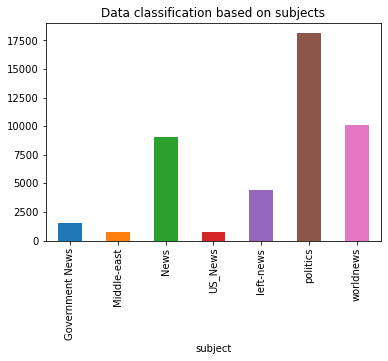

In [9]:
print(data.groupby([SUBJECT])[TEXT].count())
data.groupby([SUBJECT])[TEXT].count().plot(kind="bar")
plt.title("Data classification based on subjects")
plt.show()

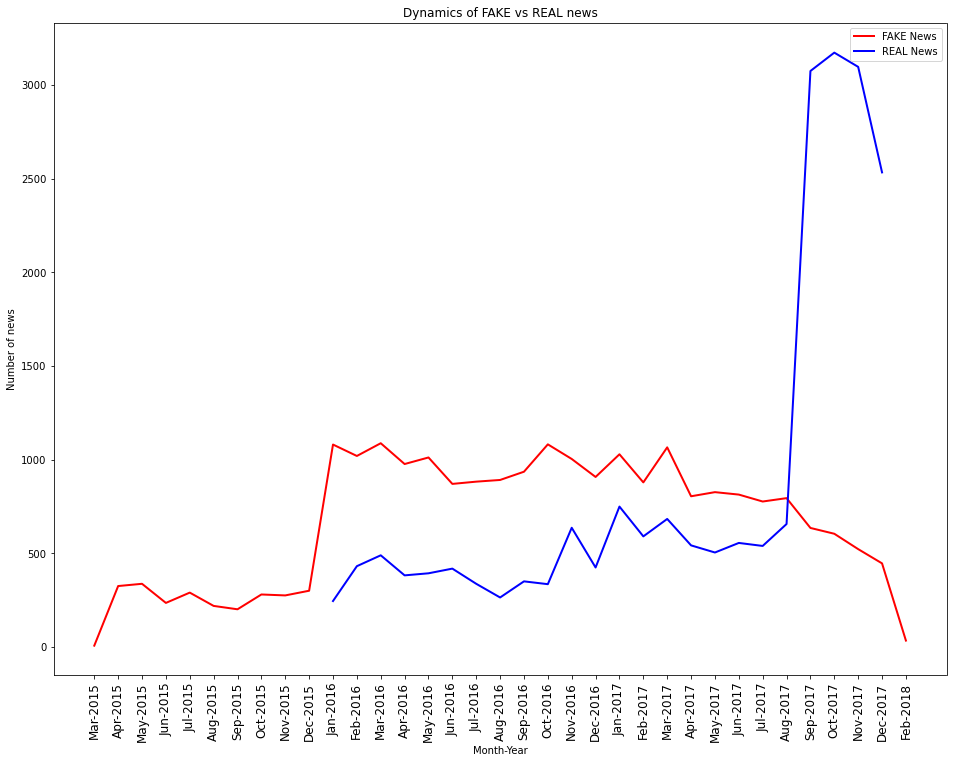

In [10]:
# Classification of data based on month and target
monthly_data_by_target = data.groupby(['month', TARGET])[TEXT].count()
monthly_data_by_target = monthly_data_by_target.reset_index(level=0)
monthly_data_by_target.month = pd.to_datetime(monthly_data_by_target.month)
monthly_data_by_target.month = monthly_data_by_target.month.apply(lambda x: x.strftime("%b-%Y"))
fake_monthly_data = monthly_data_by_target[monthly_data_by_target.index == FAKE]
real_monthly_data = monthly_data_by_target[monthly_data_by_target.index == REAL]
plt.figure(figsize=(16,12))
plt.xticks(rotation=90)
plt.ylabel('Number of news')
plt.xlabel('Month-Year')
plt.tick_params(axis='x', which='major', labelsize=12)
plt.plot(fake_monthly_data.month, fake_monthly_data.text, linewidth=2, color='red', label=FAKE+' News')
plt.plot(real_monthly_data.month, real_monthly_data.text, linewidth=2, color='blue', label=REAL+' News')
plt.title('Dynamics of FAKE vs REAL news')
plt.legend()
plt.show()

target
FAKE    23471
REAL    21417
Name: text, dtype: int64


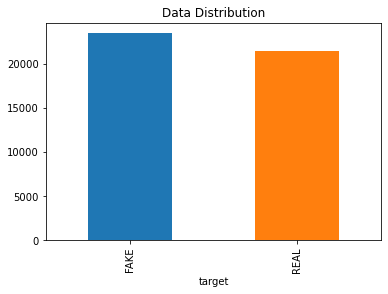

In [11]:
# Data Distribution 
print(data.groupby([TARGET])[TEXT].count())
data.groupby([TARGET])[TEXT].count().plot(kind="bar")
plt.title("Data Distribution")
plt.show()

In [12]:
def create_word_cloud(selected_data, column_text, title):
    all_words = ' '.join([text for text in selected_data[column_text]])

    wordcloud = WordCloud(width= 800, height= 500, max_font_size = 110, collocations = False).generate(all_words)
    plt.figure(figsize=(10,7))
    plt.title(title)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    
# Get the most frequently used words from the data set
token_space = tokenize.WhitespaceTokenizer()
def counter(text, column_text, quantity, category):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                 "Frequency": list(frequency.values())})    
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count", xlabel = (category + " Word"))
    plt.xticks(rotation='vertical')
    plt.title("Most frequently used " + category +" words")
    plt.show()

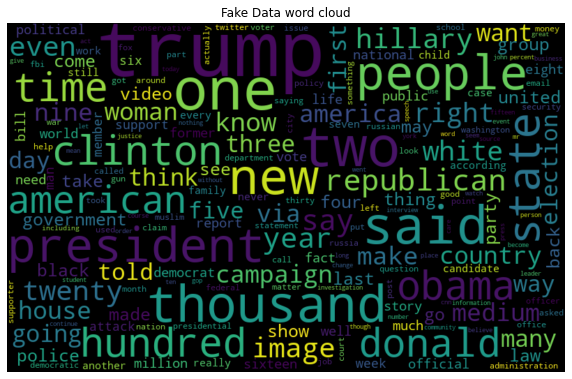

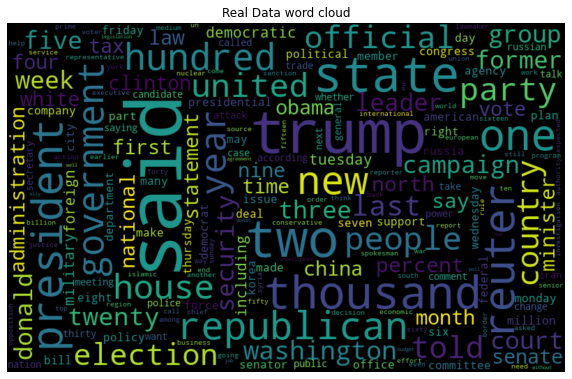

In [13]:
# Wordcloud for Fake and Real News
create_word_cloud(data[data[TARGET] == FAKE], TEXT, "Fake Data word cloud")
create_word_cloud(data[data[TARGET] == REAL], TEXT, "Real Data word cloud")

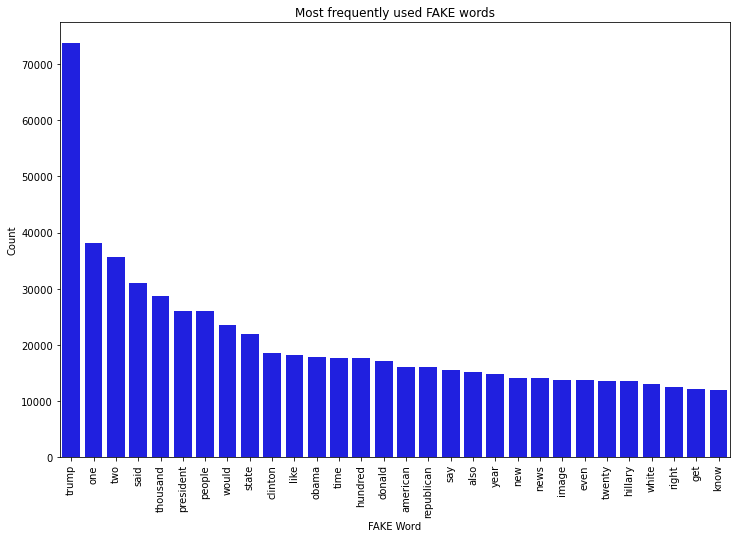

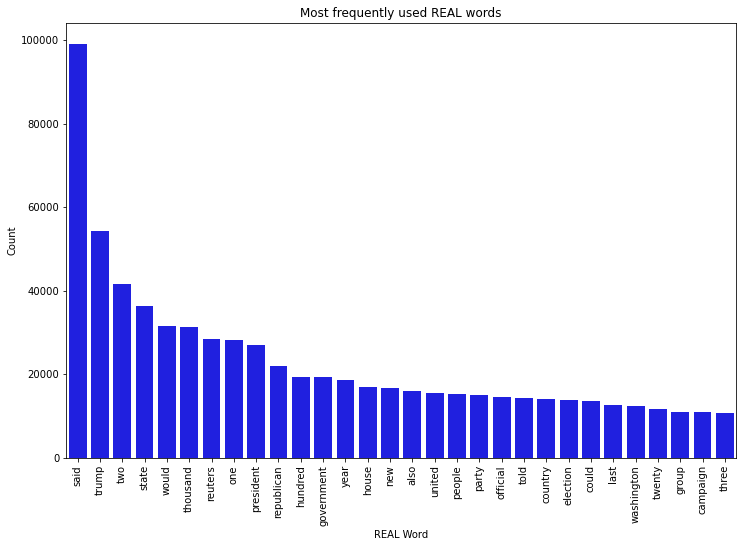

In [14]:
# Most frequently used words
counter(data[data[TARGET] == FAKE], TEXT, 30, FAKE)
counter(data[data[TARGET] == REAL], TEXT, 30, REAL)

# Data Modelling

In [15]:
# Plot confusion matrix to better understand and visualize the prediction results
def plot_confusion_matrix(classes,
                          prediction,
                          test_target,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    cm = metrics.confusion_matrix(test_target, prediction)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [16]:
def predict_model(model, target):
    
    # Predict the model for selected target
    prediction = model.predict(target)    
    return prediction

In [17]:
def convert_text_to_int(input):
    results = []
    for i in input:
        if i == FAKE:
            results.append(0)
        else:
            results.append(1)
            
    return results

def calculate_roc_curve(model_name, arr, x_label):
    train_results = []
    test_results = []
    for ar in arr:
        if model_name == "SVM":
            pipe = construct_svm_model(ar)
        elif model_name == "DT":
            pipe = construct_dt_model(ar)
        elif model_name == "RF":
            pipe = construct_rf_model(ar)
        elif model_name == "NB":
            pipe = construct_nb_model(ar)
        else:
            print("Model Not supported for ROC Curve. Please enter one among - SVM, DT, RF, NB.")
            break 
                
        # Predict model
        train_prediction = predict_model(pipe, X_train)
        test_prediction = predict_model(pipe, X_test)
        
        # Convert prediction results to numeric format        
        train_pred = convert_text_to_int(train_prediction)
        test_pred = convert_text_to_int(test_prediction)
        train_target = convert_text_to_int(y_train)
        test_target = convert_text_to_int(y_test)
        
        # Calculate ROC and Area Under Curve (AUC) for training and test data
        false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(train_target, train_pred)
        roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
        train_results.append(roc_auc)
    
        false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(test_target, test_pred)
        roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
        test_results.append(roc_auc)
        
    plt.plot(arr, train_results, linewidth=2, color='red', label='Train AUC')
    plt.plot(arr, test_results, linewidth=2, color='blue', label='Test AUC')
    plt.ylabel('AUC score')
    plt.xlabel(x_label)
    plt.legend()
    plt.show()

In [18]:
# 80% data used for training and rest 20% used for testing
X_train,X_test,y_train,y_test = train_test_split(data[TEXT], data.target, test_size=0.2, random_state=42)

# Logistic Regression Classifier

accuracy: 98.66%
Confusion matrix, without normalization


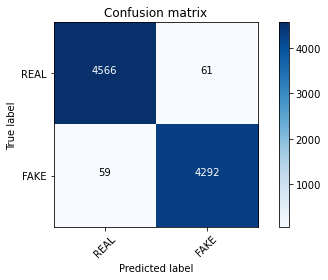

In [19]:
def construct_tfidf_model():
    pipe = Pipeline([('vect', CountVectorizer()),  # convert text to a matrix of token counts
                 ('tfidf', TfidfTransformer()), # transform a count matrix to a normalized tf-idf representation
                 ('model', LogisticRegression(random_state = 0))])

    # Fitting the model
    pipe.fit(X_train, y_train)
    
    return pipe

# Create model
pipe_tfidf = construct_tfidf_model()
# Accuracy
prediction_tfidf = predict_model(pipe_tfidf, X_test)
print("accuracy: {}%".format(round(metrics.accuracy_score(y_test, prediction_tfidf)*100,2)))
# Plot confusion matrix
plot_confusion_matrix(TARGET_NAMES, prediction_tfidf, y_test)


# Support Vector Machine Classifier

accuracy: 98.93%
Confusion matrix, without normalization


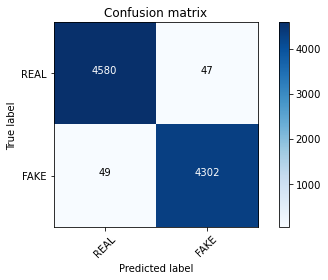

In [20]:
def construct_svm_model(C):
    pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LinearSVC(C=C))])
    
    # Fitting the model
    pipe.fit(X_train, y_train)
    
    return pipe

# Create model
pipe_svm = construct_svm_model(0.1)
# Accuracy
prediction_svm = predict_model(pipe_svm, X_test)
print("accuracy: {}%".format(round(metrics.accuracy_score(y_test, prediction_svm)*100,2)))
# Plot confusion matrix
plot_confusion_matrix(TARGET_NAMES, prediction_svm, y_test)

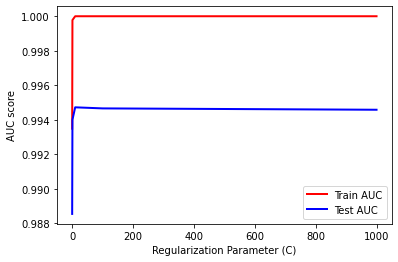

In [83]:
# Behaviour of model with varying Regularization Parameter
calculate_roc_curve("SVM", [0.1, 1, 10, 100, 1000], 'Regularization Parameter (C)')

Regularization Parameter (C) tells the SVM optimization how much to avoid misclassifying each training example. For large values of C, the optimization will choose a smaller-margin hyperplane if that hyperplane does a better job of getting all the training points classified correctly. Conversely, a very small value of C will cause the optimizer to look for a larger-margin separating hyperplane, even if that hyperplane misclassifies more points.

In this model, as C increases, the model becomes overfit. This is inline with expected results.

# Decision Tree Classifier

accuracy: 99.65%
Confusion matrix, without normalization


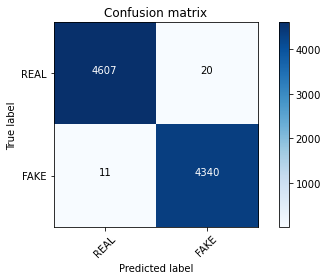

In [21]:
def construct_dt_model(max_depth):
    pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = max_depth, 
                                           splitter='best', # evaluates all splits using the criterion before splitting 
                                           random_state=42))])
    
    # Fitting the model
    pipe.fit(X_train, y_train)
    
    return pipe

# Create model
pipe_dt = construct_dt_model(7)
# Accuracy
prediction_dt = predict_model(pipe_dt, X_test)
print("accuracy: {}%".format(round(metrics.accuracy_score(y_test, prediction_dt)*100,2)))
# Plot confusion matrix
plot_confusion_matrix(TARGET_NAMES, prediction_dt, y_test)

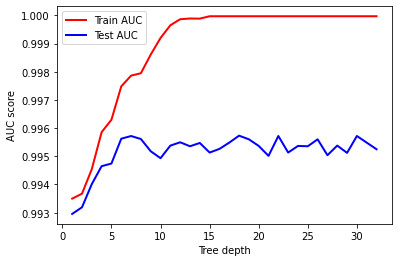

In [103]:
# Behaviour of model with varying tree depths
calculate_roc_curve("DT", np.linspace(1, 32, 32, endpoint=True), 'Tree depth')

Max depth controls the depth of the tree. The deeper the tree grows, more complex the model will become because there will be more splits and it captures more information about the data and this is one of the root causes of overfitting in decision trees. The model will fit perfectly for the training data and will not be able to generalize well on test set.

In line with this, our Decision Tree starts displaying characteristics of overfitting for large tree depth values. Beyond the depth of 8, the model starts to become overfit. 

# Random Forest Classifier

accuracy: 97.64%
Confusion matrix, without normalization


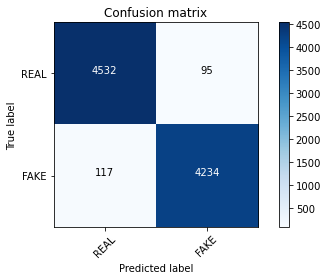

In [22]:
def construct_rf_model(estimators):
    pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', RandomForestClassifier(
                                 n_estimators=estimators, # Adding max_depth is reducing the accuracy to less than 94%
                                 criterion="entropy", 
                                 random_state = 0))])
    
    # Fitting the model
    pipe.fit(X_train, y_train)
    
    return pipe

# Create model
pipe_rf = construct_rf_model(17)
# Accuracy
prediction_rf = predict_model(pipe_rf, X_test)
print("accuracy: {}%".format(round(metrics.accuracy_score(y_test, prediction_rf)*100,2)))
# Plot confusion matrix
plot_confusion_matrix(TARGET_NAMES, prediction_rf, y_test)

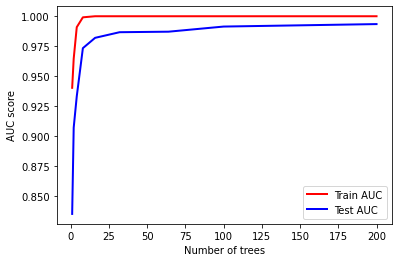

In [107]:
# Behaviour of model with varying number of trees
calculate_roc_curve("RF", [1, 2, 4, 8, 16, 32, 64, 100, 200], 'Number of trees')

As the number of tree increases, the performance is better, but the model becomes slower and more complex. Here, the model performance sharply increases and then stagnates at a certain level. Although, the model does not degrade, but the computational complexity could be prevented. Optimal range is between 15 - 20 trees based on the graph above. More granular AUC-ROC curve could help to identify the optimal number of trees.  

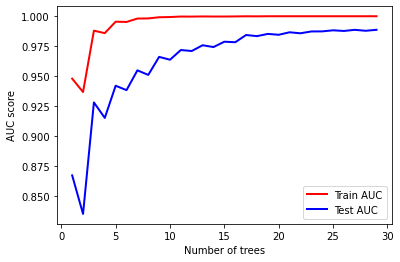

In [148]:
# Behaviour of model with varying number of trees at more granular level
calculate_roc_curve("RF", list(range(1, 30)), 'Number of trees')

In continuation from above result, the optimal number is 17. Beyond which, the model stagnates

# Naive Bayes Classifier

accuracy: 95.82%
Confusion matrix, without normalization


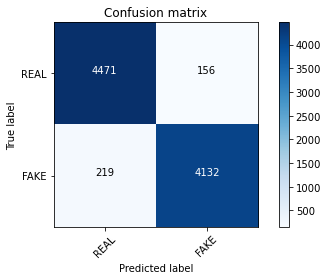

In [23]:
def construct_nb_model(alpha):
    pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', MultinomialNB(alpha = alpha))])  # alpha = 1 - Laplace smoothing, alpha < 1 - Lidstone smoothing
    
    # Fitting the model
    pipe.fit(X_train, y_train)

    return pipe

# Create model
pipe_nb = construct_nb_model(0.01)

# Accuracy
prediction_nb = predict_model(pipe_nb, X_test)
print("accuracy: {}%".format(round(metrics.accuracy_score(y_test, prediction_nb)*100,2)))
# Plot confusion matrix
plot_confusion_matrix(TARGET_NAMES, prediction_nb, y_test)

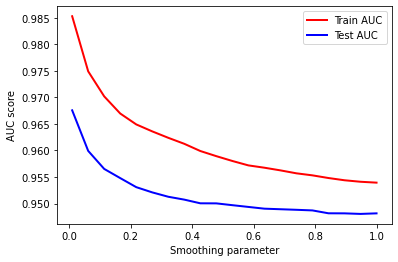

In [129]:
# Behaviour of model with varying smoothing parameter
calculate_roc_curve("NB", np.linspace(0.01, 1, 20, endpoint=True), 'Smoothing parameter')

Smoothing parameter - alpha, controls the form of the model. As the smoothing parameter is increased, the model is not able to learn enough about the data. This is causing underfitting.

# Validation Data Cleaning

In [24]:
def clean_validation_data(validation):
    
    validation[TARGET] = REAL #np.random.choice(TARGET_NAMES, validation.shape[0])  # Randomly allot values
    validation = shuffle(validation)
    validation.reset_index(drop = True)
    validation.station = validation.station.str.replace('FOX', FOX)
    # Remove variations of same stations and use a common name like CNN, FOX or MSNBC
    validation.station = validation.station.apply(lambda x: FOX if FOX in x else x) 
    validation.station = validation.station.apply(lambda x: CNN if CNN in x else x)
    validation.station = validation.station.apply(lambda x: MSNBC if MSNBC in x else x)

    validation[TEXT] = text_cleaning(validation[TEXT])
    validation[TEXT] = validation.text.apply(lambda x: re.sub("\d*", "", x))  # removing numbers in text which cannot be converted to words
    validation[TEXT] = text_cleaning(validation[TEXT])

    validation['year'] = validation[DATE].dt.to_period('Y')
    validation['month'] = validation[DATE].dt.to_period('M')
    validation['month'] = validation['month'].astype(str)
    
    return validation;


In [25]:
# Clean validation data. Validation data is unseen data used to test the performance of the model
validation_data_1 = clean_validation_data(validation1[[TITLE, TEXT, STATION, DATE]])
validation_data_2 = clean_validation_data(validation2[[TITLE, TEXT, STATION, DATE]])

station
CNN      902
Fox      249
MSNBC    188
Name: text, dtype: int64


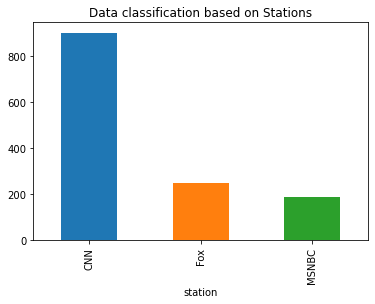

station
CNN       826
Fox      1372
MSNBC     370
Name: text, dtype: int64


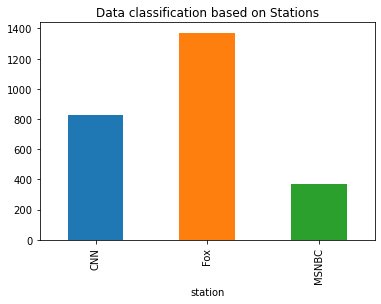

In [26]:
def plot_data_classification_plot(validation):
    
    print(validation.groupby([STATION])[TEXT].count())
    validation.groupby([STATION])[TEXT].count().plot(kind="bar")
    plt.title("Data classification based on Stations")
    plt.show()
    
plot_data_classification_plot(validation_data_1)
plot_data_classification_plot(validation_data_2)

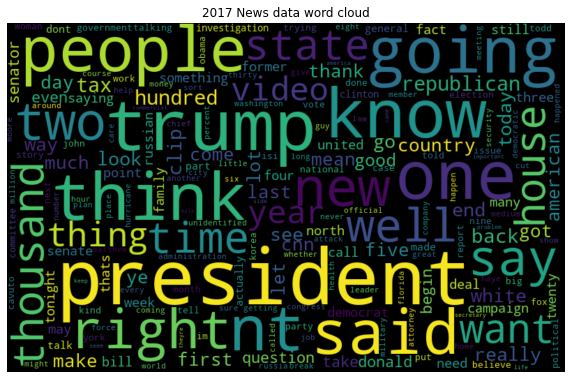

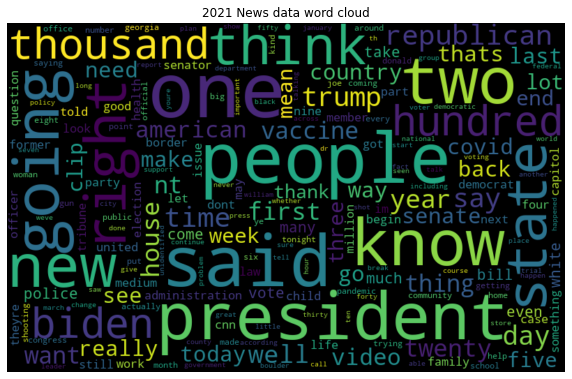

In [27]:
# Create Word cloud for validation data
create_word_cloud(validation_data_1, TEXT, "2017 News data word cloud")
create_word_cloud(validation_data_2, TEXT, "2021 News data word cloud")

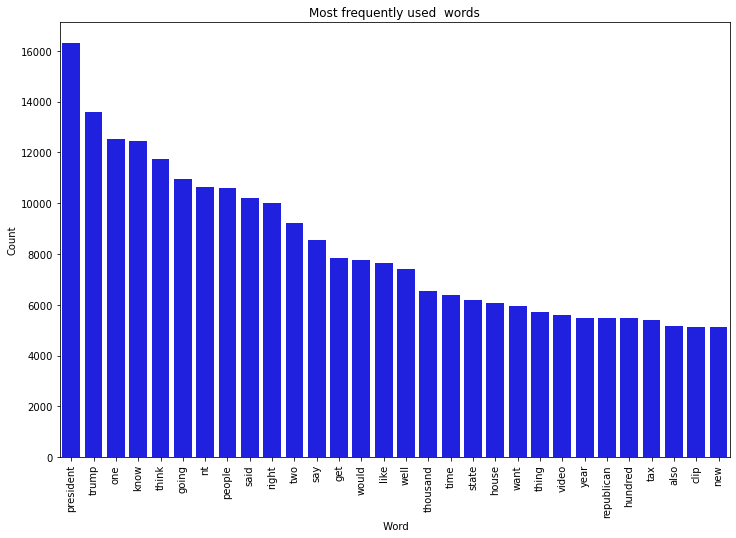

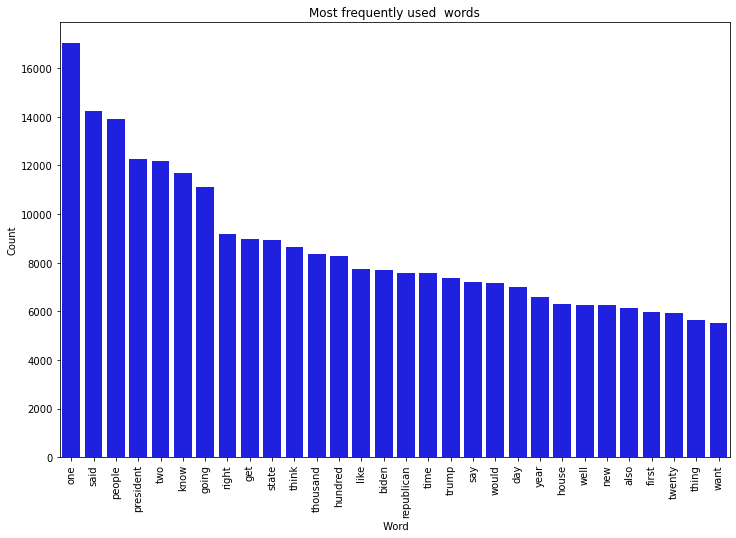

In [28]:
# Most frequently used words from validation data
counter(validation_data_1, TEXT, 30, "")
counter(validation_data_2, TEXT, 30, "")

# Logistic Regression Classifier

In [29]:
def test_tfidf_model(validation, search_word, set_info):

    test_X = validation[validation.station.str.contains(search_word)].text
    test_y = validation[validation.station.str.contains(search_word)].target
    
    if test_X.empty:
        print("No data matching the criteria found!!")
        return

    prediction_tfidf = predict_model(pipe_tfidf, test_X)
    print(search_word + " Station's Classification Report for " + set_info + " : ")
    print(metrics.classification_report(test_y, prediction_tfidf))
    

In [40]:
# Test model based on news media station for both validation data sets
test_tfidf_model(validation_data_1, FOX, "Validation Dataset 1")
test_tfidf_model(validation_data_2, FOX, "Validation Dataset 2")
test_tfidf_model(validation_data_1, CNN, "Validation Dataset 1")
test_tfidf_model(validation_data_2, CNN, "Validation Dataset 2")
test_tfidf_model(validation_data_1, MSNBC, "Validation Dataset 1")
test_tfidf_model(validation_data_2, MSNBC, "Validation Dataset 2")

Fox Station's Classification Report for Validation Dataset 1 : 
             precision    recall  f1-score   support

       FAKE       0.00      0.00      0.00         0
       REAL       1.00      0.00      0.01       249

avg / total       1.00      0.00      0.01       249

Fox Station's Classification Report for Validation Dataset 2 : 
             precision    recall  f1-score   support

       FAKE       0.00      0.00      0.00         0
       REAL       1.00      0.09      0.17      1372

avg / total       1.00      0.09      0.17      1372

CNN Station's Classification Report for Validation Dataset 1 : 
             precision    recall  f1-score   support

       FAKE       0.00      0.00      0.00         0
       REAL       1.00      0.34      0.51       902

avg / total       1.00      0.34      0.51       902

CNN Station's Classification Report for Validation Dataset 2 : 
             precision    recall  f1-score   support

       FAKE       0.00      0.00      0.00   

# Support Vector Machine Classifier

In [31]:
def test_svm_model(validation, search_word, set_info):

    test_X = validation[validation.station.str.contains(search_word)].text
    test_y = validation[validation.station.str.contains(search_word)].target
    
    if test_X.empty:
        print("No data matching the criteria found!!")
        return

    prediction_svm = predict_model(pipe_svm, test_X)
    print(search_word + " Station's Classification Report for " + set_info + " : ")
    print(metrics.classification_report(test_y, prediction_svm))

In [41]:
# Test model based on news media station for both validation data sets
test_svm_model(validation_data_1, FOX, "Validation Dataset 1")
test_svm_model(validation_data_2, FOX, "Validation Dataset 2")
test_svm_model(validation_data_1, CNN, "Validation Dataset 1")
test_svm_model(validation_data_2, CNN, "Validation Dataset 2")
test_svm_model(validation_data_1, MSNBC, "Validation Dataset 1")
test_svm_model(validation_data_2, MSNBC, "Validation Dataset 2")

Fox Station's Classification Report for Validation Dataset 1 : 
             precision    recall  f1-score   support

       FAKE       0.00      0.00      0.00         0
       REAL       1.00      0.00      0.01       249

avg / total       1.00      0.00      0.01       249

Fox Station's Classification Report for Validation Dataset 2 : 
             precision    recall  f1-score   support

       FAKE       0.00      0.00      0.00         0
       REAL       1.00      0.09      0.17      1372

avg / total       1.00      0.09      0.17      1372

CNN Station's Classification Report for Validation Dataset 1 : 
             precision    recall  f1-score   support

       FAKE       0.00      0.00      0.00         0
       REAL       1.00      0.33      0.50       902

avg / total       1.00      0.33      0.50       902

CNN Station's Classification Report for Validation Dataset 2 : 
             precision    recall  f1-score   support

       FAKE       0.00      0.00      0.00   

# Decision Tree Classifier

In [33]:
def test_dt_model(validation, search_word, set_info):

    test_X = validation[validation.station.str.contains(search_word)].text
    test_y = validation[validation.station.str.contains(search_word)].target
    
    if test_X.empty:
        print("No data matching the criteria found!!")
        return

    prediction_dt = predict_model(pipe_dt, test_X)
    print(search_word + " Station's Classification Report for " + set_info + " : ")
    print(metrics.classification_report(test_y, prediction_dt))


In [42]:
# Test model based on news media station for both validation data sets
test_dt_model(validation_data_1, FOX, "Validation Dataset 1")
test_dt_model(validation_data_2, FOX, "Validation Dataset 2")
test_dt_model(validation_data_1, CNN, "Validation Dataset 1")
test_dt_model(validation_data_2, CNN, "Validation Dataset 2")
test_dt_model(validation_data_1, MSNBC, "Validation Dataset 1")
test_dt_model(validation_data_2, MSNBC, "Validation Dataset 2")

Fox Station's Classification Report for Validation Dataset 1 : 
             precision    recall  f1-score   support

       FAKE       0.00      0.00      0.00         0
       REAL       1.00      0.00      0.01       249

avg / total       1.00      0.00      0.01       249

Fox Station's Classification Report for Validation Dataset 2 : 
             precision    recall  f1-score   support

       FAKE       0.00      0.00      0.00         0
       REAL       1.00      0.02      0.04      1372

avg / total       1.00      0.02      0.04      1372

CNN Station's Classification Report for Validation Dataset 1 : 
             precision    recall  f1-score   support

       FAKE       0.00      0.00      0.00         0
       REAL       1.00      0.01      0.01       902

avg / total       1.00      0.01      0.01       902

CNN Station's Classification Report for Validation Dataset 2 : 
             precision    recall  f1-score   support

       FAKE       0.00      0.00      0.00   

# Naive Bayes Classifier

In [35]:
def test_nb_model(validation, search_word, set_info):

    test_X = validation[validation.station.str.contains(search_word)].text
    test_y = validation[validation.station.str.contains(search_word)].target
    
    if test_X.empty:
        print("No data matching the criteria found!!")
        return

    prediction_nb = predict_model(pipe_nb, test_X)
    print(search_word + " Station's Classification Report for " + set_info + " : ")
    print(metrics.classification_report(test_y, prediction_nb))

In [43]:
# Test model based on news media station for both validation data sets
test_nb_model(validation_data_1, FOX, "Validation Dataset 1")
test_nb_model(validation_data_2, FOX, "Validation Dataset 2")
test_nb_model(validation_data_1, CNN, "Validation Dataset 1")
test_nb_model(validation_data_2, CNN, "Validation Dataset 2")
test_nb_model(validation_data_1, MSNBC, "Validation Dataset 1")
test_nb_model(validation_data_2, MSNBC, "Validation Dataset 2")

Fox Station's Classification Report for Validation Dataset 1 : 
             precision    recall  f1-score   support

       FAKE       0.00      0.00      0.00         0
       REAL       1.00      0.02      0.03       249

avg / total       1.00      0.02      0.03       249

Fox Station's Classification Report for Validation Dataset 2 : 
             precision    recall  f1-score   support

       FAKE       0.00      0.00      0.00         0
       REAL       1.00      0.19      0.31      1372

avg / total       1.00      0.19      0.31      1372

CNN Station's Classification Report for Validation Dataset 1 : 
             precision    recall  f1-score   support

       FAKE       0.00      0.00      0.00         0
       REAL       1.00      0.44      0.61       902

avg / total       1.00      0.44      0.61       902

CNN Station's Classification Report for Validation Dataset 2 : 
             precision    recall  f1-score   support

       FAKE       0.00      0.00      0.00   

# Random Forest Classifier

In [37]:
def test_rf_model(validation, search_word, set_info):

    test_X = validation[validation.station.str.contains(search_word)].text
    test_y = validation[validation.station.str.contains(search_word)].target
    
    if test_X.empty:
        print("No data matching the criteria found!!")
        return

    prediction_rf = predict_model(pipe_rf, test_X)
    print(search_word + " Station's Classification Report for " + set_info + " : ")
    print(metrics.classification_report(test_y, prediction_rf))

In [44]:
# Test model based on news media station for both validation data sets
test_rf_model(validation_data_1, FOX, "Validation Dataset 1")
test_rf_model(validation_data_2, FOX, "Validation Dataset 2")
test_rf_model(validation_data_1, CNN, "Validation Dataset 1")
test_rf_model(validation_data_2, CNN, "Validation Dataset 2")
test_rf_model(validation_data_1, MSNBC, "Validation Dataset 1")
test_rf_model(validation_data_2, MSNBC, "Validation Dataset 2")

Fox Station's Classification Report for Validation Dataset 1 : 
             precision    recall  f1-score   support

       FAKE       0.00      0.00      0.00         0
       REAL       1.00      0.03      0.06       249

avg / total       1.00      0.03      0.06       249

Fox Station's Classification Report for Validation Dataset 2 : 
             precision    recall  f1-score   support

       FAKE       0.00      0.00      0.00         0
       REAL       1.00      0.13      0.23      1372

avg / total       1.00      0.13      0.23      1372

CNN Station's Classification Report for Validation Dataset 1 : 
             precision    recall  f1-score   support

       FAKE       0.00      0.00      0.00         0
       REAL       1.00      0.36      0.53       902

avg / total       1.00      0.36      0.53       902

CNN Station's Classification Report for Validation Dataset 2 : 
             precision    recall  f1-score   support

       FAKE       0.00      0.00      0.00   